# Summarize Results of Model Training
Find the best model for each porblem

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from pathlib import Path
import pandas as pd
import json

Configuration

In [16]:
prop, level = 'oxidation_potential', 'cp2k_b3lyp_tzvpd-acn-adiabatic'

## Load all records
The last thing our training script does is write `params.json`. Find these files then load in the assoicated data

In [17]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 17 completed runs


In [18]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'params.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    output['level_count'] = len(output['lower_levels'])
    return output

Gather results and sort by the error with no data available about the molecule (most common case in our pipelines)

In [19]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('level_0_mean_absolute_error')
summary.groupby('target_method').head(1)[['path', 'epochs', 'target_method', 'level_0_mean_absolute_error']]

,path,epochs,target_method,level_0_mean_absolute_error
16,runs/model=EGNN-prop=oxidation_potential_cp2k_...,128,cp2k_b3lyp_tzvpd-acn-adiabatic,0.169955
8,runs/model=EGNN-prop=oxidation_potential_mopac...,128,mopac_pm7-acn-adiabatic,0.180533


Save summary to CSV for later use

In [20]:
summary.to_csv('model-summary.csv', index=False)

## Plot Performance of Best Model
Plot the predicted vs actual and the learning as a function of epoch

In [21]:
target_runs = summary.query(f'target_property=="{prop}" and target_method=="{level}" and level_count>=2').sort_values('level_0_mean_absolute_error')

In [23]:
best_run = target_runs.sort_values('level_0_mean_absolute_error').iloc[0]
best_run['model_kwargs']

{'hidden_dim': 64,
 'num_conv': 4,
 'pool_before_output': 1,
 'pool_operation': 'mean',
 'num_output_layers': 4}

In [24]:
best_run

path                           runs/model=EGNN-prop=oxidation_potential_cp2k_...
starting_model                                                              runs
seed                                                                    12156906
data_path                                                    ../datasets/mdf-mos
learning_rate                                                             0.0005
weight_decay                                                                 0.0
model_kwargs                   {'hidden_dim': 64, 'num_conv': 4, 'pool_before...
num_loaders                                                                    4
batch_size                                                                    64
model                                                                       EGNN
epochs                                                                       128
fast_runs                                                                   None
target_property             

Predicted vs Actual

In [25]:
test_data = pd.read_csv(best_run.path / 'test_results.csv.gz')
print('

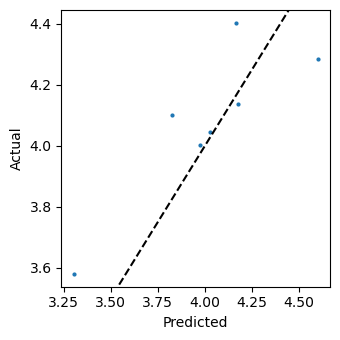

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['level_0-pred'], test_data['true'], s=4)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig.tight_layout()

## Show the effect of adding levels
The error should go down the more information we have about the molecule

In [27]:
n_levels = len(best_run['lower_levels']) + 1
print(f'Displaying results with {n_levels} levels of data: {best_run["lower_levels"]}')

Displaying results with 4 levels of data: ['xtb-adiabatic', 'cp2k_b3lyp_svp-acn-vertical', 'cp2k_b3lyp_svp-acn-adiabatic']


Show the MAE as a function of level

Text(0, 0.5, 'MAE (V)')

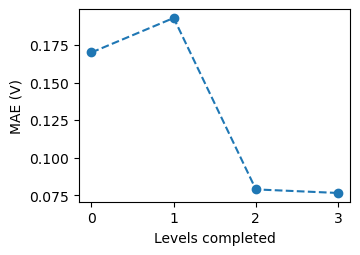

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

maes = [best_run[f'level_{i}_mean_absolute_error'] for i in range(n_levels)]
ax.plot(maes, '--o')

ax.set_xlabel('Levels completed')
ax.set_ylabel('MAE (V)')

Plot predicted-vs-actual for each level

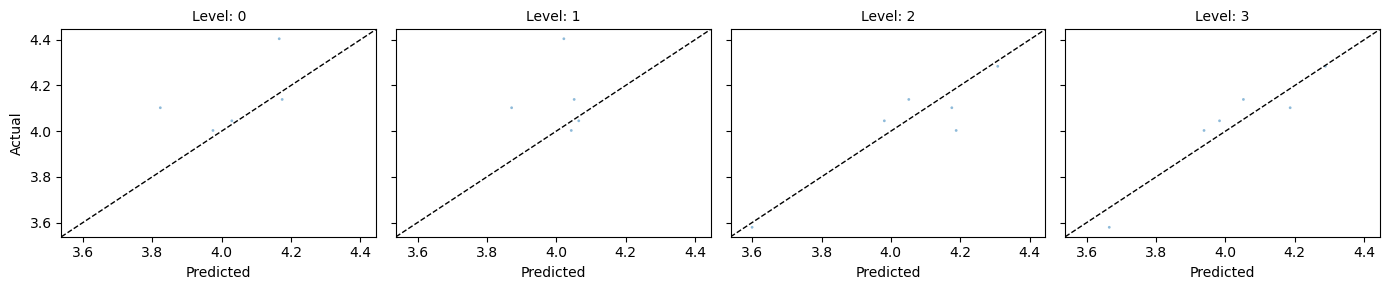

In [29]:
fig, axs = plt.subplots(1, n_levels, figsize=(3.5 * n_levels, 3.), sharey=True, sharex=True)

for level, ax in enumerate(axs):
    ax.scatter(test_data[f'level_{level}-pred'], test_data['true'], s=4, edgecolor='none', alpha=0.5)
    ax.set_title(f'Level: {level}', fontsize=10)
    ax.set_xlabel('Predicted')
    
# Add the y=x line
for ax in axs:
    ax.set_xlim(ax.get_ylim())
    ax.set_ylim(ax.get_ylim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)


axs[0].set_ylabel('Actual')
fig.tight_layout()

## Store Best Model for Each Property
Save the type and kwargs for each level

In [30]:
best_dir = Path('best_models')
best_dir.mkdir(exist_ok=True)
for (prop, level), group in summary.groupby(['target_property', 'target_method']):
    (best_dir / f'{prop}-{level}.json').write_text(
        json.dumps(group.drop(columns='path').sort_values('level_0_r2_score').iloc[-1].to_dict(), indent=2)
    )